In [1]:
import pandas as pd
import sys
import os
os.chdir("C:\\Users\\Zber\\Documents\\Dev_program\\OpenRadar")
import numpy as np
import mmwave.dsp as dsp
import mmwave.dsp.music as music
import mmwave.clustering as clu
from mmwave.dataloader import DCA1000
from demo.visualizer.visualize import ellipse_visualize
from FER.data_processing.mediapipe_facemesh_one import flm_detector, distance
from scipy import signal

from mmwave.dsp.utils import Window
from mmwave.dsp import utils
import math
from FER.utils import parseConfigFile, arange_tx

from itertools import accumulate
from operator import add
from mmwave.dsp.cfar import ca

from scipy.signal import find_peaks, peak_widths

import matplotlib.pyplot as plt

from sklearn import metrics

from mpl_toolkits.mplot3d import Axes3D

plt.close('all')

DebugMode = True

if not DebugMode:
    import matplotlib

    matplotlib.use('Agg')

# plotting color
import matplotlib._color_data as mcd

tab_color = [mcd.TABLEAU_COLORS[name] for name in mcd.TABLEAU_COLORS]
extra_color = ['#acc2d9', '#56ae57', '#b2996e', '#a8ff04']
tab_color = tab_color + extra_color

In [3]:
csv_path ='C:/Users/Zber/Documents/Dev_program/OpenRadar/FER/results/Supervision_heatmap_landmark_20220522-000305/metrics.csv'
df = pd.read_csv (csv_path, sep='\t')

In [ ]:
def plot_cl_mnist(ax, accs, flops):
    ind = np.arange(len(accs))  # the x locations for the groups
    width = 0.28  # the width of the bars
    ax2 = ax.twinx()
    rects1 = ax.bar(ind - width/2, accs, width, edgecolor = 'black',color='#58D2C9',
                    label='Accuracy',linewidth=1)
    rects2 = ax2.bar(ind + width/2, flops, width, edgecolor = 'black',color = '#FF545A', 
                     label='FLOPs',linewidth=1)

    handles, labels = ax.get_legend_handles_labels()
    new_handles, new_labels = ax2.get_legend_handles_labels()
    H = handles + new_handles
    L = labels + new_labels
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel("Accuracy%",fontsize=30)
    ax2.set_ylabel("FLOPs(M)",fontsize=30)
    ax.yaxis.set_tick_params(labelsize=30,length=5)    
    ax2.yaxis.set_tick_params(labelsize=30,length=5)
    ax.set_xticks(ind)
    ax.set_xticklabels(('TF', 'RIC','TF+RIC', 'Full Size'),fontsize=22)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax.set_ylim(70,100)

    return H, L

<function matplotlib.pyplot.show(close=None, block=None)>

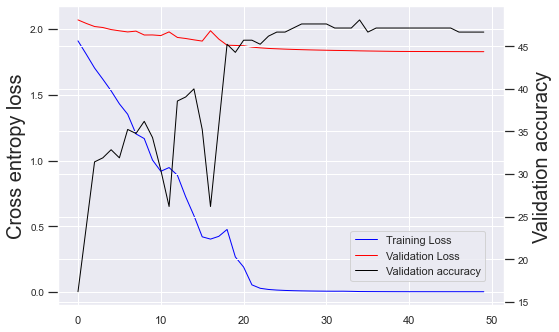

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5.5))
ax2 = ax.twinx()
ax.plot(df['train_loss'], color='blue', label='Training Loss',linewidth=1)
ax.plot(df['test_loss'], color='red', label='Validation Loss',linewidth=1)
ax2.plot(df['precision'], color='black', label='Validation accuracy',linewidth=1)
ax.yaxis.set_tick_params(labelsize=10,length=10)    
ax2.yaxis.set_tick_params(labelsize=10,length=10)
ax.set_ylabel("Cross entropy loss",fontsize=20)
ax2.set_ylabel("Validation accuracy",fontsize=20)
handles, labels = ax.get_legend_handles_labels()
new_handles, new_labels = ax2.get_legend_handles_labels()
H = handles + new_handles
L = labels + new_labels
fig.legend(H, L, loc='center', bbox_to_anchor=(0.5, 0., 0.5, 0.5))

plt.show

In [3]:
np_path = "C:/Users/Zber/Desktop/Subjects_Heatmap_new/S1/Anger_0_ele.npy"
d = np.load(np_path)
d.shape

(300, 91, 10)

### Wearing Results

In [41]:
#wearing results

emotion_list = ['Neutral', 'Joy', 'Surprise', 'Anger', 'Sadness', 'Fear', 'Disgust']
res_root = "C:\\Users\\Zber\\Documents\\Dev_program\\OpenRadar\\FER\\results"
# res_folder = "Evaluate_olddata_ours_W_1_2_3_v2_20220530-174743"
# res_folder = "Evaluate_olddata_ours_W_1_2_3_v1_20220530-173637"
# res_folder = "Evaluate_olddata_ours_W_1_2_3_v4_20220530-185201"
# res_folder = "Evaluate_olddata_ours_W_1_2_3_v3_20220530-184812"
res_folder = "Evaluate_olddata_ours_W_1_2_3_20220530-190129"
folder_path = os.path.join(res_root, res_folder)
ann_file = "C:\\Users\\Zber\\Desktop\\Subjects_Heatmap\\heatmap_test_W1_2_3.txt"
subs = []
df = pd.read_csv (os.path.join(folder_path, "metrics.csv"), sep='\t')
with open(ann_file) as f:
    sub_file = f.readlines()

for s in sub_file:
    subs.append(s[:s.index('/')])

# print(subs)
predict = np.asarray(df['predict'])
target = np.asarray(df['target'])

n_w1 = subs.count("W1")
n_w2 = subs.count('W2')


w1_predict = predict[:n_w1].astype(int)
w1_target = target[:n_w1].astype(int)

w2_predict = predict[n_w1:n_w2+n_w1].astype(int)
w2_target = target[n_w1:n_w2+n_w1].astype(int)


w3_predict = predict[n_w2+n_w1:].astype(int)
w3_target = target[n_w2+n_w1:].astype(int)


w1_p, w1_r, w1_f, w1_s = metrics.precision_recall_fscore_support(w1_target, w1_predict, average='macro')
w2_p, w2_r, w2_f, w2_s = metrics.precision_recall_fscore_support(w2_target, w2_predict, average='macro')
w3_p, w3_r, w3_f, w3_s = metrics.precision_recall_fscore_support(w3_target, w3_predict, average='macro')
# w1_p = metrics.precision_recall_fscore_support(w1_target, w1_predict, labels=emotion_list, average='macro')
# w1_p= metrics.accuracy_score(w1_target, w1_predict)
# w2_p= metrics.accuracy_score(w2_target, w2_predict)
# w3_p= metrics.accuracy_score(w3_target, w3_predict)


# print(w1_p)
# print(w2_p)
# print(w3_p)


print(w1_predict)
print(w1_target)


print(w2_predict)
print(w2_target)


print(w3_predict)
print(w3_target)

print(w1_p)
print(w2_p)
print(w3_p)






[0 3 3 1 1 1 2 2 2 3 6 3 4 4 4 6 5 6 1 5 6]
[0 0 0 1 1 1 2 2 2 3 3 3 4 4 4 5 5 5 6 6 6]
[0 0 4 1 1 1 2 2 6 6 3 3 4 4 4 6 5 5 6 6 6]
[0 0 0 1 1 1 2 2 2 3 3 3 4 4 4 5 5 5 6 6 6]
[0 0 0 1 3 1 2 2 2 3 1 3 4 4 4 5 5 5 6 3 3]
[0 0 0 1 1 1 2 2 2 3 3 3 4 4 4 5 5 5 6 6 6]
0.7142857142857143
0.8928571428571429
0.8666666666666666


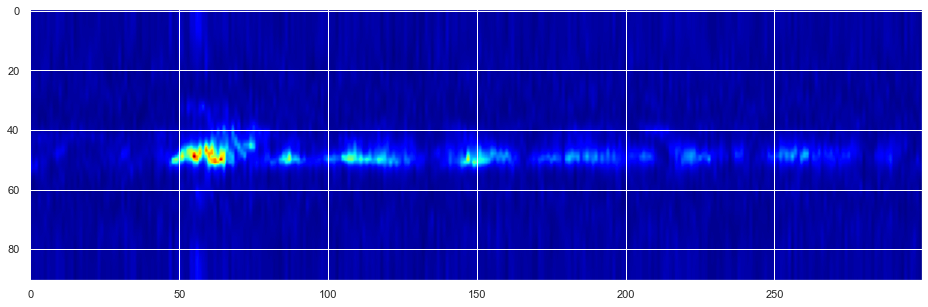

In [4]:
fig1, axes1 = plt.subplots(1, 1, figsize=(16, 9))
np_path = "C:/Users/Zber/Desktop/Capon_Heatmap/30cm/Surprise_2.npy"
data = np.load(np_path)
axes1.imshow(data, cmap=plt.cm.jet)